### Loading data

In [1]:
import cv2 as cv
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_csv = "train.csv"
train_meta_df = pd.read_csv(train_csv)

print(train_meta_df.shape)
train_meta_df.head()

(39209, 8)


,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


### using the width and height to remove images below `limit_size`

In [3]:
limit_size=44 # drop all where width and height < this value

width_indexer = train_meta_df["Width"] >= limit_size
height_indexer = train_meta_df["Height"] >= limit_size

indexer = np.logical_and(width_indexer, height_indexer)

train_meta_df = train_meta_df[indexer]

In [4]:
train_meta_df.shape

(18339, 8)

#### Loading procedure
We are going to use an ImageGenerator that reads from a DataFrame (the dataframe above).<br>
Before that, we shall add non-class fields. So, we must load them and add them to the meta_df above as class 0.
We must then shift the other classes by 1 so that class 0 is not overwritten

In [5]:
df = train_meta_df.copy()
df = df[["ClassId", "Path"]]
df["ClassId"] = df["ClassId"]
print(df.shape)
df.head()

(18339, 2)


,ClassId,Path
18,20,Train/20/00020_00000_00018.png
19,20,Train/20/00020_00000_00019.png
20,20,Train/20/00020_00000_00020.png
21,20,Train/20/00020_00000_00021.png
22,20,Train/20/00020_00000_00022.png


In [6]:
add_nons=False
if add_nons: # add non-traffic
    non_path = "dataset//Train//Non"
    non_data, non_labels = [], []
    contents = os.listdir(non_path)

    data = {"ClassId":[], "Path":[]}

    for path in contents:
        impath = os.path.join("Train/Non/"+path)
        data["ClassId"].append(0)
        data["Path"].append(impath)

    non_data_df = pd.DataFrame(data)

    main_df = pd.concat([df, non_data_df], ignore_index=True)
    print(main_df.shape)
else:
    main_df=df

### A little EDA

NClasses : 43


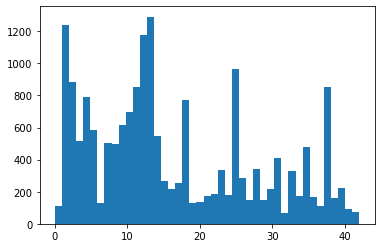

In [7]:
labels = main_df["ClassId"].values
class_ids = np.unique(labels)
nclasses = len(class_ids)
print("NClasses :", nclasses)
plt.hist(labels, bins=nclasses)
plt.show()

The classes are not from a balanced dataset. Hopefully this will be resolved by the image data generator

### Taking a look at benchmark accuracy

In [8]:
indices = np.arange(len(labels))
np.random.shuffle(indices)
shuffled = np.array(labels)[indices]

sum(shuffled==np.array(labels)) / len(labels)

0.03909700637984623

So, we can assume that a model that achieves an accuracy above 0.3% has done well.

### Splitting dataframe into train and validation set, with stratification
Stratification ensures that the same percentage of classes exists in the train and validation set

In [9]:
from sklearn.model_selection import train_test_split
x_indices = np.arange(len(labels))
y = labels

train_indices, val_indices, y_train, y_val = train_test_split(x_indices, y, test_size=0.2, random_state=42, stratify=y)

len(y_train), len(y_val)

(14671, 3668)

In [10]:
train_df = pd.DataFrame(main_df.values[train_indices])
val_df = pd.DataFrame(main_df.values[val_indices])
train_df.columns = main_df.columns
val_df.columns = main_df.columns

train_df["ClassId"] = train_df["ClassId"].astype(np.int32)
val_df["ClassId"] = val_df["ClassId"].astype(np.int32)

print("TRAIN DF.shape :", train_df.shape)
print("VAL DF.shape :", val_df.shape)

train_df.head()

TRAIN DF.shape : (14671, 2)
VAL DF.shape : (3668, 2)


,ClassId,Path
0,13,Train/13/00013_00045_00010.png
1,9,Train/9/00009_00037_00017.png
2,18,Train/18/00018_00025_00022.png
3,5,Train/5/00005_00057_00028.png
4,12,Train/12/00012_00011_00023.png


**Verifying stratification**

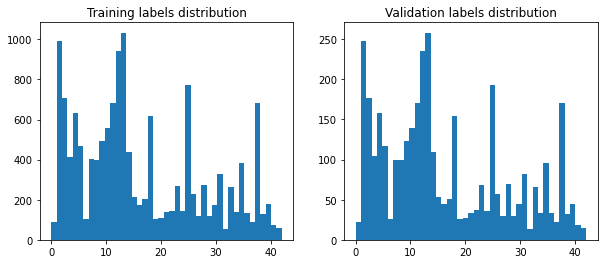

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2)
axes[0].hist(y_train, bins=nclasses)
axes[0].set_title("Training labels distribution")
axes[1].hist(y_val, bins=nclasses)
axes[1].set_title("Validation labels distribution")
fig.set_size_inches(10, 4)
plt.show()

Well distributed!

### Creating the data generator

In [12]:
from keras.preprocessing.image import ImageDataGenerator
imsize=80
batch_size=32

params = {
    "x_col":"Path",
    "y_col":"ClassId",
    "class_mode":"other",
    "batch_size":batch_size,
    "color_mode":"rgb",
    "shuffle":True
}

data_generator = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True
)

train_data_generator = data_generator.flow_from_dataframe(
    train_df,
    directory="dataset",
    target_size=(imsize, imsize),
    **params
)

validation_data_generator = data_generator.flow_from_dataframe(
    val_df,
    directory="dataset",
    target_size=(imsize, imsize),
    **params
)

Found 14671 validated image filenames.
Found 3668 validated image filenames.


**A small test for our generator**

In [13]:
# running this unit will fetch off one batch; so currently disabled
if False:
    look = 11
    for X, y in train_data_generator:
        for i in range(len(y)):
            if y[i] == look:
                image = X[i]
                plt.imshow(image)
                break
        print(y)
        break

### Model creation

In [14]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten

In [15]:
def make_model():
    reg = keras.regularizers.l1(0.01)
    init = "he_uniform"
    drop_rate=0.2

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=(imsize, imsize, 3), 
                     kernel_regularizer=reg, kernel_initializer=init))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=drop_rate))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', kernel_regularizer=reg, kernel_initializer=init))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(rate=drop_rate))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', kernel_regularizer=reg, kernel_initializer=init))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu', kernel_regularizer=reg, kernel_initializer=init))
    model.add(Dropout(rate=0.2))
    model.add(Dense(43, activation='softmax'))

    #Compilation of the model
    model.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

In [16]:
save_path = "model43_30_regv.h5"
model = None
try:
    model = keras.models.load_model(save_path)
    print("MODEL LOADED @'{}'".format(save_path))
except Exception as e:
    print(e)
    model = make_model()
    print("MODEL CREATED...")
model.summary()

No file or directory found at model43_30_regv.h5
MODEL CREATED...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 76, 76, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 38, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 38, 38, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 36, 36, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 18, 18, 64)       0         
 2D)                                                             
                                                        

In [ ]:
history = model.fit(
    train_data_generator,
    steps_per_epoch = len(y_train)//batch_size,
    validation_data=validation_data_generator,
    validation_steps=len(y_val)//batch_size,
    epochs=5)

Epoch 1/5
208/458 [============>.................] - ETA: 5:45 - loss: 38.9808 - accuracy: 0.0652

In [ ]:
model.save(save_path)

## Testing Model

### Testing internally

In [ ]:
model.evaluate(validation_data_generator, steps=len(y_val)//batch_size)

In [ ]:
test_meta_df = pd.read_csv("dataset//Test.csv")
test_meta_df.head()

In [ ]:
width_indexer = test_meta_df["Width"] >= limit_size
height_indexer = test_meta_df["Height"] >= limit_size

indexer = np.logical_and(width_indexer, height_indexer)

test_meta_df = test_meta_df[indexer]

In [ ]:
test_df = test_meta_df.copy()[["ClassId", "Path"]]
test_df["ClassId"] = test_df["ClassId"].values
test_df.head()

In [ ]:
test_data_generator = data_generator.flow_from_dataframe(
    test_df,
    directory="dataset",
    target_size=(imsize, imsize),
    **params
)

model.evaluate(test_data_generator, steps=len(test_df)//batch_size)

In [ ]:
for batch in test_data_generator:
    X, y = batch
    proba = model.predict(X)
    y_pred = proba.argmax(axis=1)
    true_indexer = (y==y_pred)
    selectionX, selectiony = X[true_indexer], y[true_indexer]
    break

In [ ]:
len(selectiony)

In [ ]:
classes = { 0:"None",
            1:'Speed limit (20km/h)',
            2:'Speed limit (30km/h)', 
            3:'Speed limit (50km/h)', 
            4:'Speed limit (60km/h)', 
            5:'Speed limit (70km/h)', 
            6:'Speed limit (80km/h)', 
            7:'End of speed limit (80km/h)', 
            8:'Speed limit (100km/h)', 
            9:'Speed limit (120km/h)', 
            10:'No passing', 
            11:'No passing veh over 3.5 tons', 
            12:'Right-of-way at intersection', 
            13:'Priority road', 
            14:'Yield', 
            15:'Stop', 
            16:'No vehicles', 
            17:'Veh > 3.5 tons prohibited', 
            18:'No entry', 
            19:'General caution', 
            20:'Dangerous curve left', 
            21:'Dangerous curve right', 
            22:'Double curve', 
            23:'Bumpy road', 
            24:'Slippery road', 
            25:'Road narrows on the right', 
            26:'Road work', 
            27:'Traffic signals', 
            28:'Pedestrians', 
            29:'Children crossing', 
            30:'Bicycles crossing', 
            31:'Beware of ice/snow',
            32:'Wild animals crossing', 
            33:'End speed + passing limits', 
            34:'Turn right ahead', 
            35:'Turn left ahead', 
            36:'Ahead only', 
            37:'Go straight or right', 
            38:'Go straight or left', 
            39:'Keep right', 
            40:'Keep left', 
            41:'Roundabout mandatory', 
            42:'End of no passing', 
            43:'End no passing veh > 3.5 tons' }

### Testing externally

In [ ]:
img = cv.imread("Test//00115.png")

if True: # add noise
    nsize = int(imsize*0.6)
    r = cv.resize(img, (nsize, nsize))
    img = cv.resize(r, (imsize, imsize))
else:
    img = cv.resize(img, (imsize, imsize))
img = img/255.0

plt.imshow(img)
plt.show()

In [ ]:
proba = model.predict(np.array([img]))

In [ ]:
np.round(proba, 3)

In [ ]:
pred = np.argmax(proba[0])
pred

In [ ]:
classes[pred+1]

### Other models

In [79]:
## VGG 224
base = keras.applications.vgg16.VGG16(
   include_top = False, 
   weights = 'imagenet', 
   input_shape = (imsize, imsize, 3), 
   #pooling = None, 
   classes = 1000
)

layers = base.layers
for i in range(len(layers)):
    layer = layers[i]
    trainable = (i > len(layers)-3)
    layer.trainable = trainable

top = Sequential()
top.add(base)
top.add(Flatten())
top.add(Dense(256, activation='relu'))
top.add(Dropout(rate=0.2))
top.add(Dense(43, activation='softmax'))

#Compilation of the model
top.compile(loss='sparse_categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])

Exception: URL fetch failure on https://storage.googleapis.com/tensorflow/keras-applications/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5: None -- [Errno 11001] getaddrinfo failed

In [ ]:
history = top.fit(
    train_data_generator,
    steps_per_epoch = len(y_train)//batch_size,
    validation_data=validation_data_generator,
    validation_steps=len(y_val)//batch_size,
    epochs=5)

In [ ]:
## mobilenet 224
top = keras.applications.mobilenet_v2.MobileNetV2 (
   input_shape = None, 
   alpha = 1.0, 
   include_top = False, 
   weights = 'imagenet', 
   input_tensor = None, 
   pooling = None, 
   classes = 1000
)

In [ ]:
keras.applications.inception_v3.InceptionV3 (
   include_top = True, 
   weights = 'imagenet', 
   input_tensor = None, 
   input_shape = None, 
   pooling = None, 
   classes = 1000
)